In [17]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    %cd /content/drive/MyDrive/polar-lows-detection-forecasting-deep-learning/additional_notebooks/
    !pip install pytorch-lightning
    !pip install captum
    !pip install timm
    !pip install torchinfo

In [ ]:
import os
import sys
import cv2
from pathlib import Path

import numpy as np
import random
import matplotlib.pyplot as plt
import torch
from PIL import Image

root = Path('..').resolve()
sys.path.insert(0, str(root))

from models import Xception
from train_setups import create_model_ckpt_setup
import train_config as tc
from train_config import transform_prep, transform_aug, device, train_dir
from image_processing import (
    convert_to_np_array,
    normalize_image_to_range,
    adversarial_erase,
    
)
from model_utils import get_layer_from_name
from attributions.gradcam import GradCAM

In [ ]:
model_path = root / 'checkpoints' / 'xception-40-800.ckpt'

tc.path_displacement = '../'

model, _, _ = create_model_ckpt_setup(Xception(), model_path)

/home/andrea/miniconda3/envs/polarlows/lib/python3.12/site-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


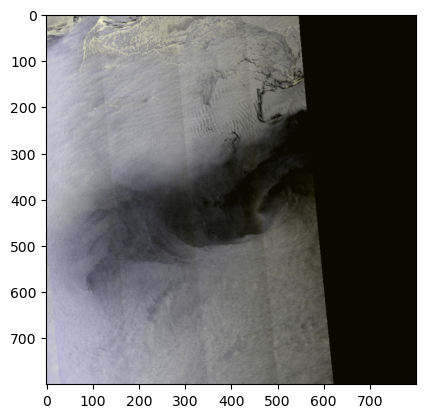

../data/train/pos/380022_20171222T192238_20171222T192428_mos_rgb.png
Predicted: pos. Actual: pos


In [20]:
# Pick random image
category = 'pos' # random.choice(['pos', 'neg'])
chosen_image = random.choice(os.listdir(os.path.join(train_dir(), category)))
image_path = os.path.join(train_dir(), category, chosen_image)

# image_path = root / 'data/train/neg/3af0a6_20180527T063102_20180527T063217_mos_rgb.png'

# Prepare image
original_image = Image.open(image_path).convert('RGB')
transformed_image = transform_prep(original_image).unsqueeze(0)

# Display image
plt.imshow(normalize_image_to_range(transformed_image.squeeze().permute(1, 2, 0).cpu().numpy(), target_range=(0, 255)))
plt.show()

print(image_path)

model.eval()
pred = torch.argmax(model(transformed_image.to(device)), dim=1).item()
print(f'Predicted: {"pos" if pred==1 else "neg"}. Actual: {category}')

We now generate the GradCAM heatmap, using as input the transformed image. Notice how the size of the activation maps depends on the layer we use. If we use a deeper layer, we usually (like in this case) have smaller activation maps. This means that the resolution of the obtained heatmap is going to be less than the one we would obtain using an earlier convolutional layer.

Selected pointwise convolution layer: body.conv4.pointwise - Conv2d(1536, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)


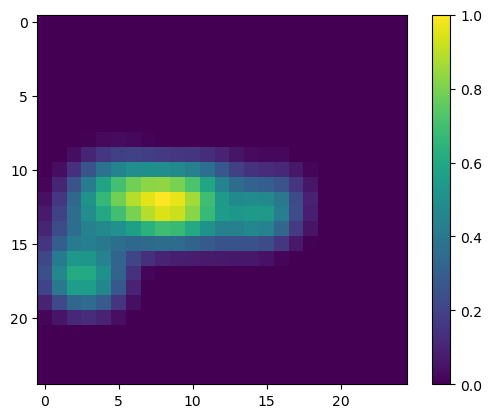

In [21]:
gc = GradCAM(model.model, device)

gradcam_heatmap = gc.generate_heatmap(transformed_image)

plt.imshow(gradcam_heatmap)
plt.colorbar()
plt.show()

Let's now start processing the heatmap in order to overlay it on the transformed image.

Since the transformed image is a Tensor, we convert it to a NumPy array and we normalize it between 0 and 255.

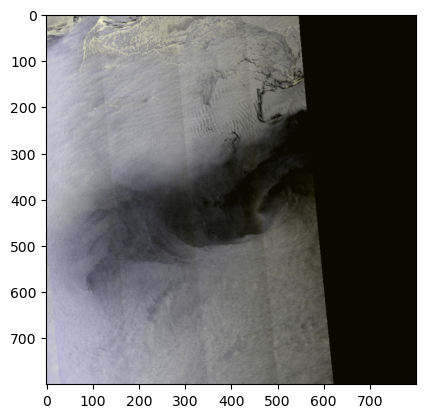

In [22]:
timg_np = transformed_image.squeeze(0).permute(1, 2, 0).numpy()
timg_np = normalize_image_to_range(timg_np, target_range=(0, 255))

plt.imshow(timg_np)
plt.show()

Then, we must resize the heatmap in order to match the dimensions of the transformed image. Here we can clearly see how the size of the original heatmap affects the resolution of the resized heatmap. If we had picked a convolutional layer that provided bigger heatmaps this resized heatmap would have had a much better resolution.

Also, we will normalize the image between 0 and 255, since the transformed image has values in that range.

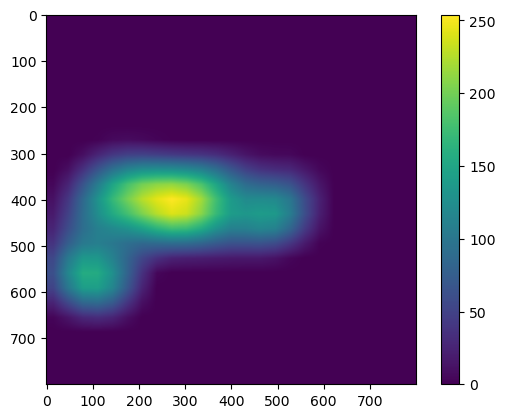

In [23]:
heatmap_resized = cv2.resize(gradcam_heatmap.cpu().numpy(), (timg_np.shape[1], timg_np.shape[0]))
heatmap_resized = np.uint8(255 * heatmap_resized)

plt.imshow(heatmap_resized)
plt.colorbar()
plt.show()

The heatmap is a grayscale image (it only has one channel). We need to convert it to 3 channels (RGB) in order to overlay it on top of the transformed image. When a colormap is applied in cv2, it takes this single-channel grayscale image and maps each intensity value to a corresponding color based on the specified color map.

One thing we must note when applying a colormap is that for pixels where the heatmap had value 0, now the RGB heatmap does not have a zero value. Instead, a color has been assigned to the 0 intensity. If we use COLORMAP_JET, for example, what used to correspond to intensity 0 now is represented by the color blue [0, 0, 128].

We will have to take this into account when adding this colored heatmap on top of the image.

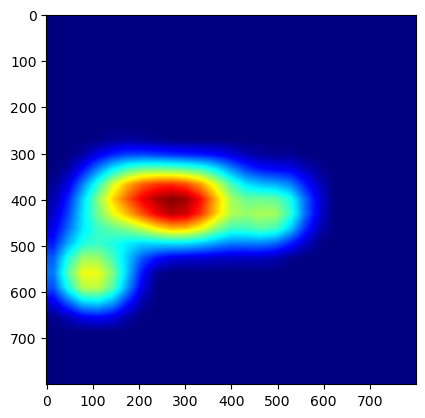

In [24]:
heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET) # Apply color map to heatmap
heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB) # Convert color space from BGR (Blue, Green, Red) to RGB

plt.imshow(heatmap_colored)
plt.show()

If the grayscale heatmap's value was close to 0, we want the overlayed colored heatmap to be more transparent. Otherwise, the whole image will get a blueish tint (considering COLORMAP_JET).

In fact, here on the left we show the overlayed heatmap without adaptive transparency. On the right, we use adaptive transparency.

(-0.5, 799.5, 799.5, -0.5)

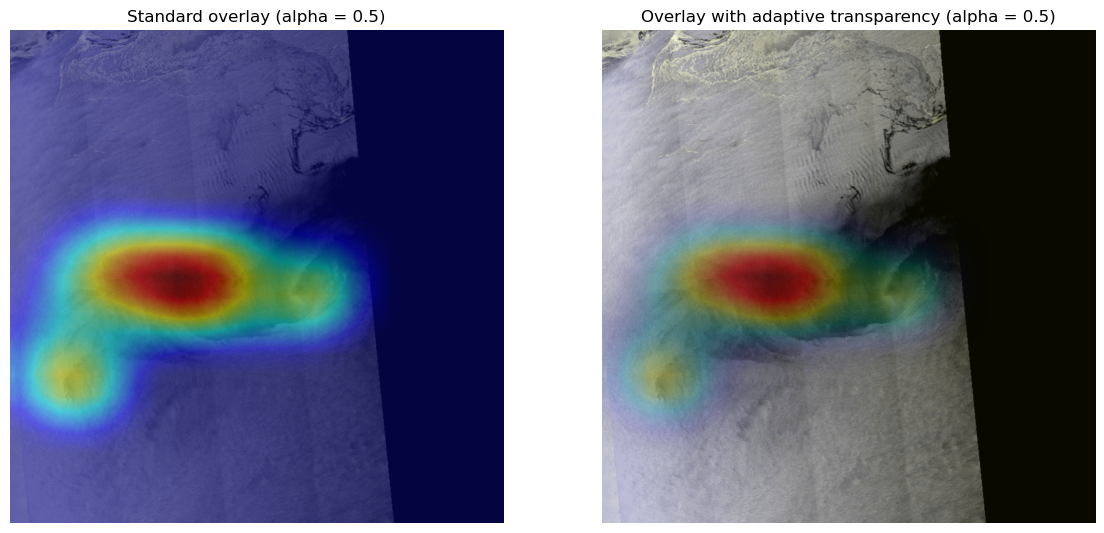

In [25]:
alpha = 0.5

ov_img = cv2.addWeighted(
    heatmap_colored, alpha, timg_np, 1 - alpha, 0
)

# Normalize values between 0 and 1 (Transparency map)
normalized_heatmap = heatmap_resized / np.max(heatmap_resized)

# Expand dimensions to match RGB channels
normalized_heatmap = np.repeat(normalized_heatmap[:, :, np.newaxis], 3, axis=2)

image_with_smooth_heatmap = (ov_img * normalized_heatmap + timg_np * (1 - normalized_heatmap)).astype(np.uint8)


plt.figure(figsize=(14, 8))

# Standard overlay
plt.subplot(1, 2, 1)
plt.imshow(ov_img)
plt.title(f'Standard overlay (alpha = {alpha})')
plt.axis('off')

# Overlay with adaptive transparency
plt.subplot(1, 2, 2)
plt.imshow(image_with_smooth_heatmap)
plt.title(f'Overlay with adaptive transparency (alpha = {alpha})')
plt.axis('off')

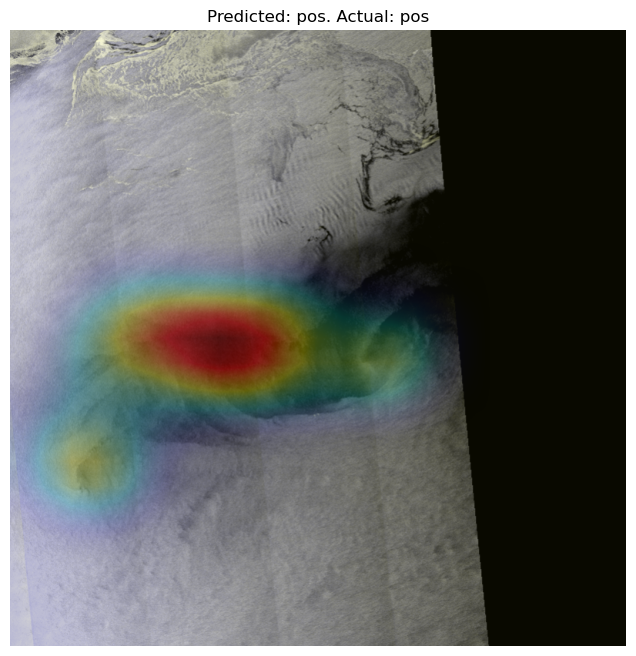

In [26]:
plt.figure(figsize=(8, 8))

plt.imshow(image_with_smooth_heatmap)
plt.title(f'Predicted: {"pos" if pred==1 else "neg"}. Actual: {category}')
plt.axis('off')

plt.show()

We can now use the generated GradCAM activations to create bounding boxes around the predicted hurricane position. They should only be generated if a hurricane is found in the image.

First, we create a binary mask starting from the GradCAM heatmap.

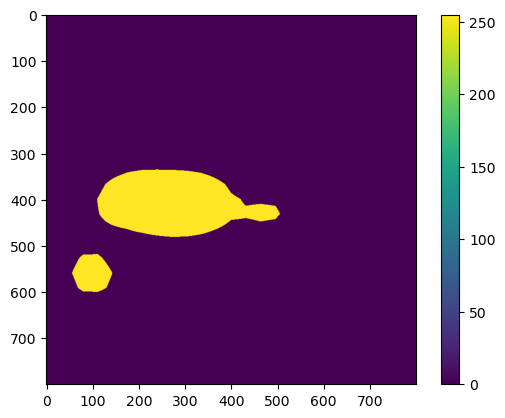

In [27]:
threshold = 0.5
_, binary_mask = cv2.threshold(heatmap_resized, threshold * 255, 255, cv2.THRESH_BINARY)

plt.imshow(binary_mask)
plt.colorbar()
plt.show()

In order to create a bounding box around the hurricane, we first find the contour of the previously obtained binary mask.

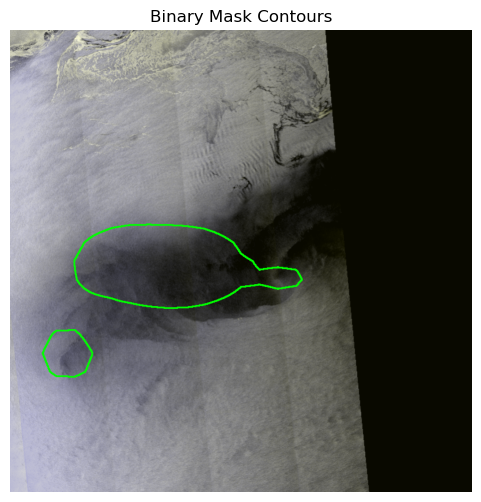

In [28]:
# Make a copy of the original image to draw contours on
image_with_contours = normalize_image_to_range(convert_to_np_array(transformed_image), target_range=(0, 255)).copy()

# Find contours in the binary mask
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours
cv2.drawContours(image_with_contours, contours, -1, (0, 255, 0), 2)  # Green contours


plt.figure(figsize=(6, 6))
plt.imshow(image_with_contours)
plt.axis("off")
plt.title("Binary Mask Contours")
plt.show()

We now create a bounding rectangle around the previously obtained contours.

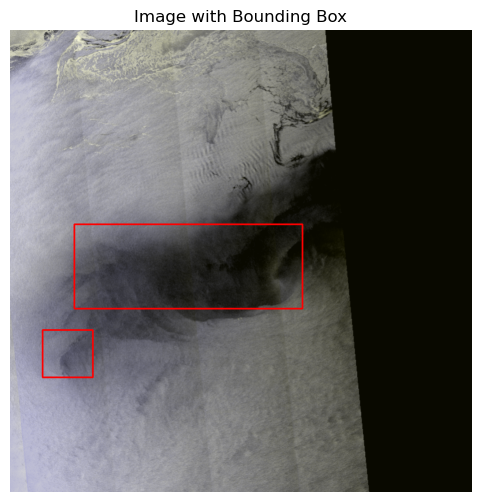

In [29]:
image_with_bounding_box = normalize_image_to_range(convert_to_np_array(transformed_image), target_range=(0, 255)).copy()

# Draw bounding box
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(image_with_bounding_box, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Red bounding box


plt.figure(figsize=(6, 6))
plt.imshow(image_with_bounding_box)
plt.axis("off")
plt.title("Image with Bounding Box")
plt.show()

In [30]:
transformed_image.shape

torch.Size([1, 3, 800, 800])

In [31]:
heatmap_resized.min(), heatmap_resized.max()

(0, 254)

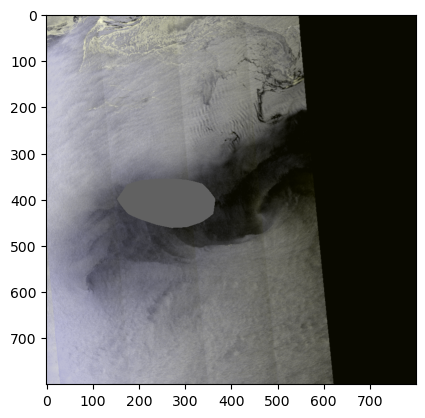

In [32]:
erased_image = adversarial_erase(transformed_image, torch.from_numpy(heatmap_resized), threshold=0.7*255)

plt.imshow(normalize_image_to_range(erased_image.squeeze().numpy().transpose(1, 2, 0)))